In [310]:
#%%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xtrack as xt
import xobjects as xo
import scipy
import xpart as xp

In [311]:
import sympy as sy
from sympy import init_session
init_session() 

IPython console for SymPy 1.13.3 (Python 3.10.12-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.3/



# Ring design

In [312]:
lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
number_of_dipoles = 2*number_of_FODO
k1 = 0.0098
pc_GeV = 20.0
lFODO = lcirc/number_of_FODO

In [313]:
env = xt.Environment()
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'qtrim_f': 0,
          'qtrim_d': 0,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_FODO,
          'lfodo': 'lcirc/number_of_fodo',
          "kick_angle" : -0.001 ,
          "kicker_length" : 2,
          "ext_kicker_angle": -0.0,
          "ext_kicker_length": 0.5,
          "l_ramp" : 2,
          })

env.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

env.new('mb', xt.Bend, length='lbend', k0='k0.mb', h='k0.mb')
env.new('mb0', 'mb') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mb1', 'mb')

#env.new('kicker', xt.Bend, knl = ["kick_angle"], length = "kicker_length")
env.new('kicker', xt.Bend, k0 = "kick_angle/kicker_length", length = "kicker_length")
env.new('ext_kicker', xt.Multipole, knl = ["ext_kicker_angle/ext_kicker_length"], length = "ext_kicker_length")
env.new('mk1', 'kicker') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mk2', 'kicker',  k0 = "-kick_angle/kicker_length")
env.new('mk3', 'kicker',  k0 = "-kick_angle/kicker_length") #create each element with unique names in cell -- required for slicing of elements used later
env.new('mk4', 'kicker')

env.vars({'ksf': 0.00, 'ksd' : 0.00 })

env.new('ms.f', xt.Multipole, knl = [0, 0, 'ksf'])
env.new('ms.d', xt.Multipole, knl = [0, 0, 'ksd'])

env.new('mq', xt.Quadrupole, length='lquad')

env.new('mq.f', 'mq', k1='k1f + qtrim_f')
env.new('mq.d', 'mq', k1='k1d + qtrim_d')

cell_moved_dipole = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.d', at=lquad*0.5),
    env.place('mb0', at='lbend/2+ lquad + 1'),
    env.place('mq.f', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='1 * lfodo - lquad - lbend/2 - 1'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

cell = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.d', at=lquad*0.5),
    env.place('mb0', at='0.25 * lfodo + lquad * 0.5'),
    env.place('mq.f', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='0.75 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])
cell.insert_element('ms.f', at = 'mq.f')
cell.insert_element('ms.d', at = 'mq.d')

Baseline ring from exercise 3

In [314]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell_moved_dipole)]*1+[env.place(cell)]*(number_of_FODO-1) )

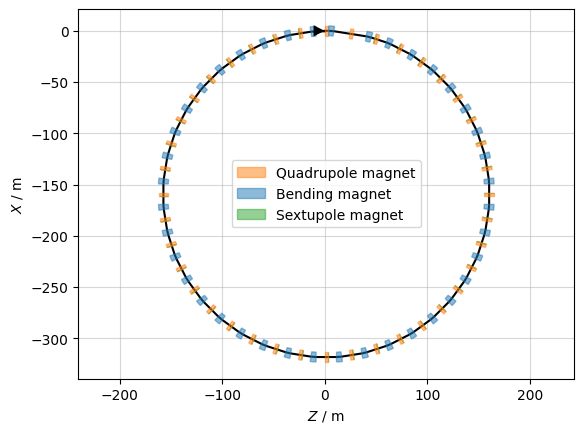

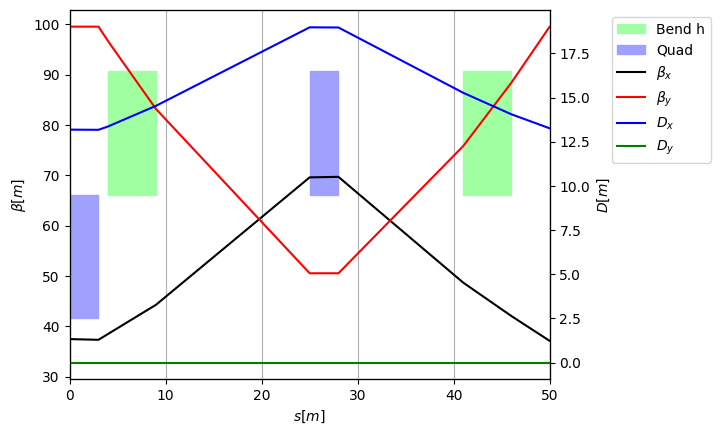

In [315]:
line.survey().plot()
line.twiss4d().plot()
plt.xlim(0,50)

## 25-9

In [ ]:
cell_kick = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.d', at=lquad*0.5),
    env.place('mb0', at='lbend/2+ lquad + 1'),
    env.place('mk1', at='lbend + lquad + 1  + kicker_length/2'),
    env.place('mk2', at='lbend+ lquad + 1 +  l_ramp + kicker_length/2'),
    env.new('marker_extraction', xt.Marker, at = 'lbend+ lquad + 7.5 + kicker_length/2'),
    env.place('mk3', at='lbend+ lquad + 1 + 15 - l_ramp - kicker_length/2'),
    env.place('mk4', at='lbend+ lquad + 1 + 15 - kicker_length/2'),
    env.place('mq.f', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='1 * lfodo - lquad - lbend/2 - 1'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

cell_ext_kick = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.d', at=lquad*0.5),
    env.place('mb0', at='0.25 * lfodo + lquad * 0.5'),
    env.place('mq.f', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb1', at='0.75 * lfodo + lquad*0.5'),
    env.place('ext_kicker', at = '100.0 * lfodo - ext_kicker_length/2'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])

In [317]:
cell_kick.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,marker_start,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.0098, k1s=0, length=3, num_mu..."
2,3.0,Drift,drift_9,True,False,None,False,Drift(length=1)
3,4.0,Bend,mb0,True,False,None,False,"Bend(length=5, k0=0.0314, k1=0, h=0.0314, mode..."
4,9.0,Bend,mk1,True,False,None,False,"Bend(length=2, k0=-0.0005, k1=0, h=0, model='a..."
5,11.0,Bend,mk2,True,False,None,False,"Bend(length=2, k0=0.0005, k1=0, h=0, model='ad..."
6,13.0,Drift,drift_10,True,False,None,False,Drift(length=3.5)
7,16.5,Marker,marker_extraction,False,False,None,False,Marker(_dummy=np.int64(0))
8,16.5,Drift,drift_11,True,False,None,False,Drift(length=3.5)
9,20.0,Bend,mk3,True,False,None,False,"Bend(length=2, k0=0.0005, k1=0, h=0, model='ad..."


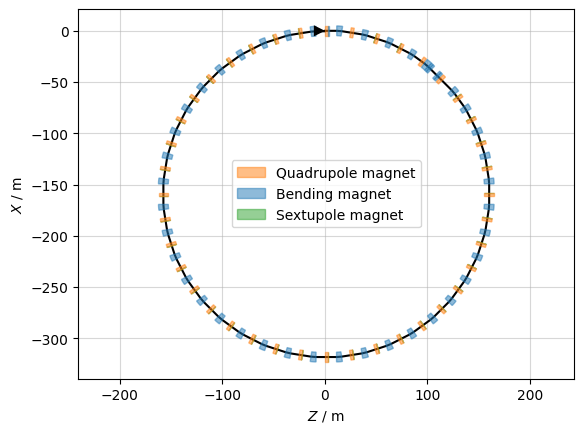

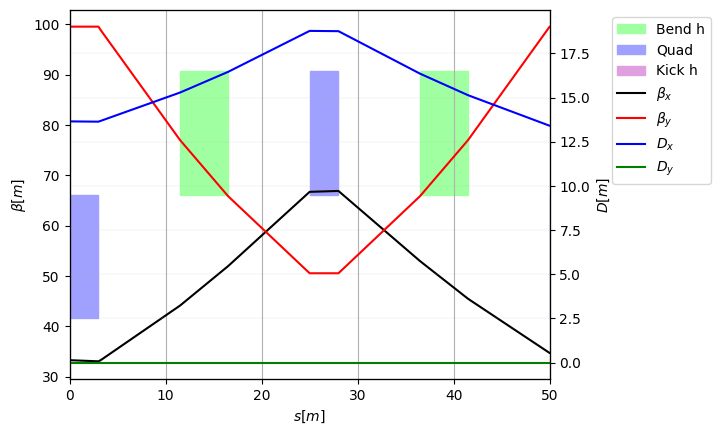

In [318]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]
                    +[env.place(cell_ext_kick)]*1
                    +[env.place(cell)]*1
                    +[env.place(cell_kick)]*1
                    +[env.place(cell)]*(number_of_FODO-3)
                    )

#line.insert_element('ext_kicker', at_s = 860)

line.survey().plot()
twiss = line.twiss4d()
twiss.plot()
plt.grid(linewidth = 0.1, which = "both")
plt.xlim(0,50)

In [319]:
tab = line.to_pandas()

print(np.where(tab.name=='marker_extraction'))
print(np.where(tab.name=='ext_kicker'))

(array([32]),)
(array([4]),)


In [320]:
print(tab)

           s element_type          name  isthick  isreplica parent_name  \
0       0.00       Marker  _start_point    False      False        None   
1       0.00       Marker  marker_start    False      False        None   
2       0.00   Quadrupole          mq.d     True      False        None   
3       3.00        Drift      drift_15     True      False        None   
4       3.25    Multipole    ext_kicker    False      False        None   
..       ...          ...           ...      ...        ...         ...   
242   978.00        Drift       drift_7     True      False        None   
243   986.50         Bend           mb1     True      False        None   
244   991.50        Drift       drift_8     True      False        None   
245  1000.00       Marker    marker_end    False      False        None   
246  1000.00                 _end_point    False      False        None   

     iscollective                                            element  
0           False           

In [321]:
print(twiss.mux[4])
print(twiss.mux[32])
print(twiss.mux[-1])

0.01582344636654609
0.38597557044415776
3.2244609043730224


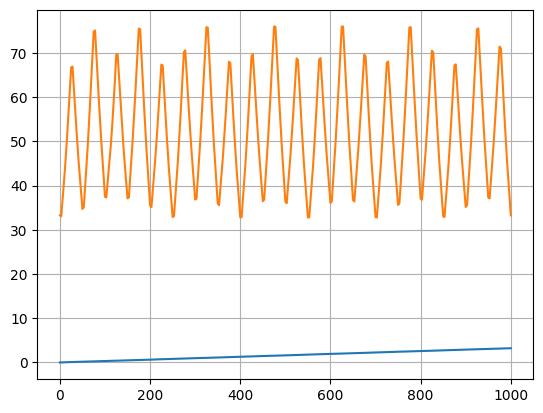

In [322]:
plt.plot(twiss.s, twiss.mux)
plt.plot(twiss.s, twiss.betx)
plt.grid()

In [323]:
print(twiss.alfx[0])
print(twiss.betx[4])

0.5683809042019461
33.3139719866117


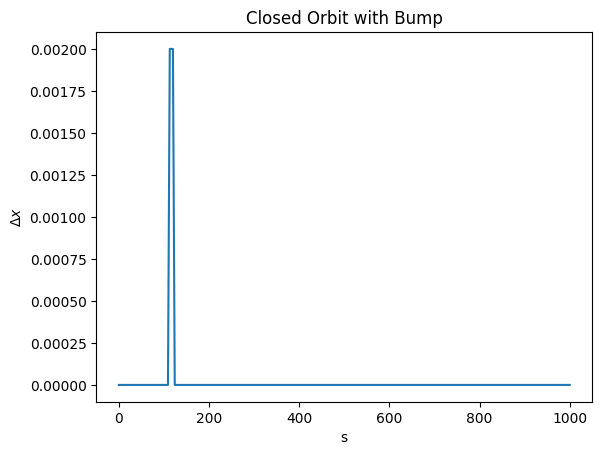

In [324]:
plt.plot(twiss.s, twiss.x)
plt.xlabel("s")
plt.ylabel(r"$\Delta x$")
plt.title("Closed Orbit with Bump")
plt.show()

The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker
The line already has an associated tracker


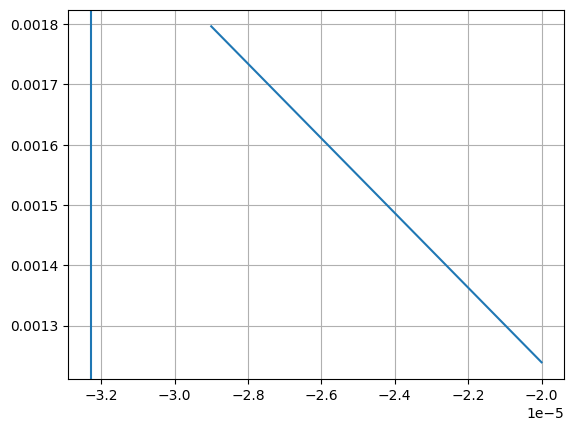

In [325]:
kick_strengths = []
deviations = []
for k in np.arange(-0.00002, -0.00003, -0.000001):
    particles = line.build_particles(num_particles=1)

    line.vars['ext_kicker_angle'] = k

    line.build_tracker()
    line.track(particles=particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')

    kick_strengths.append(k)
    record = line.record_last_track
    deviations.append(record.x[0][32])

p = np.polyfit(deviations, kick_strengths, 1)
#transfer = np.mean(np.array(kick_strengths) / (np.array(deviations) - 0.002))
transfer = np.mean((np.array(deviations) - 0.002) / np.array(kick_strengths))
kick_strength = 0.002 / transfer
plt.axvline(kick_strength)
plt.plot(kick_strengths, np.array(deviations) - 0.002)
plt.grid()

In [326]:
#particles = line.build_particles(nemitt_x=1e-9, nemitt_y=1e-9, num_particles=100)
#particles = line.build_particles(x=0, y=0, px=0, py=0, zeta=0, delta=0, num_particles=1)
#particles = xp.generate_matched_gaussian_bunch(line=line, num_particles=100, nemitt_x=1e-7, nemitt_y=1e-7, sigma_z=0.0)

#particles = line.build_particles(x_norm=np.random.normal(0.0, 1.0, 1000), px_norm=np.random.normal(0.0, 1.0, 1000), nemitt_x=1e-7, nemitt_y=1e-7, method='4d')
particles = line.build_particles(num_particles=1)

In [327]:
line.vars['ext_kicker_angle'] = kick_strength
#line.vars['ext_kicker_angle'] = 0.0

print(kick_strength)

line.build_tracker()
line.track(particles=particles, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')
record = line.record_last_track

print(record.x[0][32])

-3.228593141271283e-05
The line already has an associated tracker
0.003999982121038864


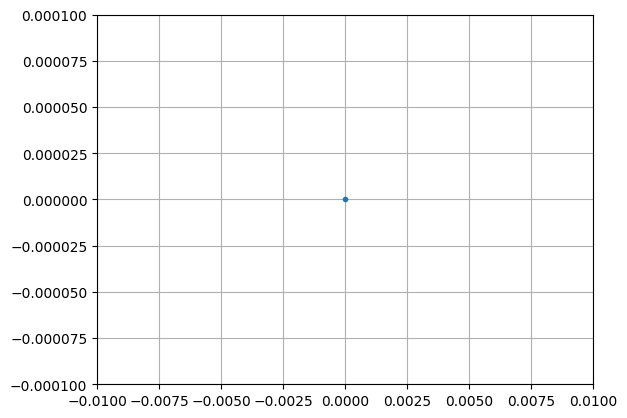

In [328]:
record = line.record_last_track
plt.plot(record.x[:, 0], record.px[:, 0], '.')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.0001, 0.0001)
plt.grid()

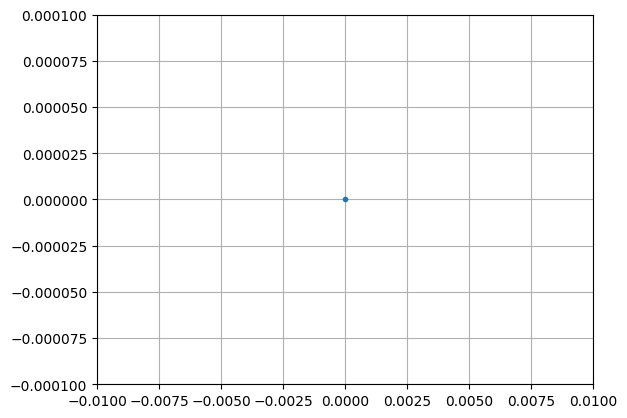

In [329]:
record = line.record_last_track
plt.plot(record.x[:, 4], record.px[:, 4], '.')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.0001, 0.0001)
plt.grid()

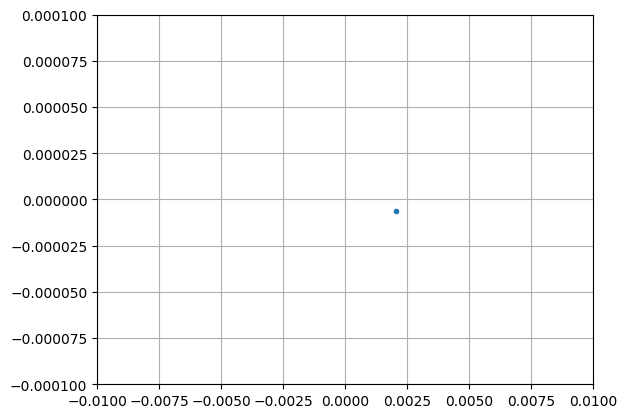

In [330]:
record = line.record_last_track
plt.plot(record.x[:, 29], record.px[:, 29], '.')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.0001, 0.0001)
plt.grid()

0.38597557044415776


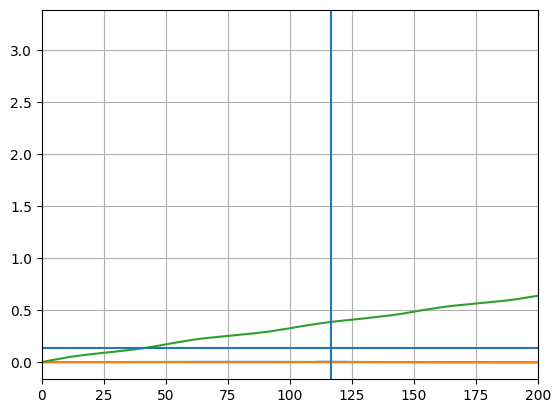

In [340]:
plt.plot(twiss.s, record.x[0])
plt.plot(twiss.s, record.px[0])
plt.plot(twiss.s, twiss.mux)
print(twiss.mux[32])
plt.axvline(twiss.s[32])
plt.axhline(twiss.mux[32] - 0.25)
plt.xlim(0, 200)
plt.grid()

In [332]:
print(record.x[0][32])

0.003999982121038864
